In [1]:
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import copy

from prob2utils_YM import train_model, get_err

%matplotlib inline

ratings = pd.read_csv(os.path.join('data', 'data.txt'), sep='\t', header=None, names=['User ID', 'Movie ID', 'Rating'])

# Read in information on movies
names = ['Movie ID', 'Movie Title', 'Unknown', 'Action',
         'Adventure', 'Animation', 'Children\'s', 'Comedy',
         'Crime', 'Documentary', 'Drama', 'Fantasy',
         'Film-Noir', 'Horror', 'Musical', 'Mystery',
         'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv(os.path.join('data', 'movies.txt'), sep='\t', header=None, encoding='latin_1', names=names)
movies['Movie Title'] = movies['Movie Title'].str.strip()

savefig_kwargs = {'dpi': 200, 'bbox_inches': 'tight', 'transparent': True}
plt.rc('pdf', fonttype=42)
#%config InlineBackend.figure_format = 'pdf'
%config InlineBackend.print_figure_kwargs = savefig_kwargs

In [2]:
# Separate movie name and year if desired
split_year = False
if split_year:
    movies.loc[266, 'Movie Title'] = 'unknown (0000)'
    movies.loc[1411, 'Movie Title'] = \
        'Land Before Time III: The Time of the Great Giving (V) (1995)'
    movies['Year'] = [int(title[-5:-1]) for title in movies['Movie Title']]
    movies['Movie Title'] = [title[:-7] for title in movies['Movie Title']]

In [3]:
# Merge ratings data with movie metadata
pdData = ratings.merge(movies, how='left', on='Movie ID')
data = np.random.permutation(pdData)

In [4]:
totRate = np.zeros(len(movies))
numRate = np.zeros(len(movies))
for y in data:
    totRate[y[1] - 1] += y[2]
    numRate[y[1] - 1] += 1
    
avgRate = totRate/numRate

rMovies = copy.deepcopy(movies)
rMovies['Average Rating'] = avgRate
rMovies['Rate Number'] = numRate

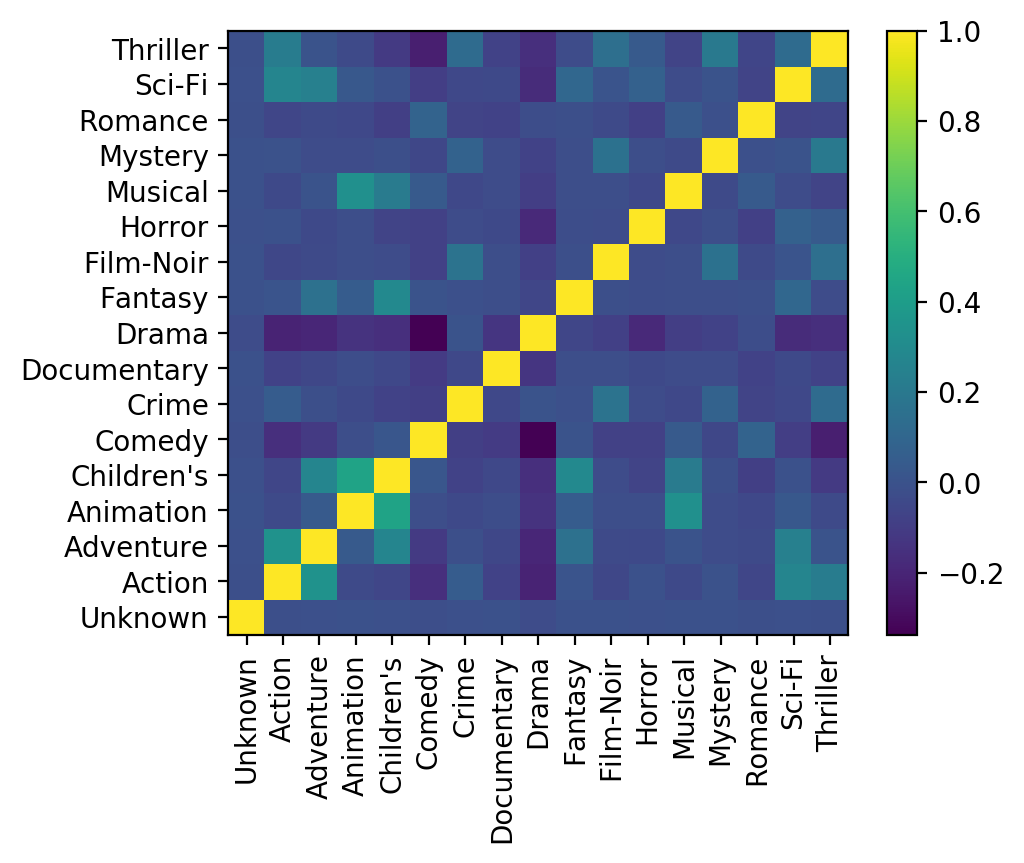

In [5]:
genreCorr = np.corrcoef(np.array(movies.iloc[:, 2:-2]).T)
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
heatmap = ax.pcolor(genreCorr)
ax.set_yticks(np.arange(genreCorr.shape[0]) + 0.5, minor=False)
ax.set_xticks(np.arange(genreCorr.shape[1]) + 0.5, minor=False)

ax.set_xticklabels(movies.columns[2:-2], minor=False, rotation=90)
ax.set_yticklabels(movies.columns[2:-2], minor=False)

fig.colorbar(heatmap)

plt.show()

In [6]:
trainData = data[0: 90000]
testData = data[90000:]

In [7]:
M = max(max(trainData[:,0]), max(testData[:,0])) # users
N = max(max(trainData[:,1]), max(testData[:,1])) # movies
print("Factorizing with ", M, " users, ", N, " movies.")


Factorizing with  943  users,  1682  movies.


In [8]:
K = 20
U, V, loss = train_model(M, N, K, 0.03, 0.32, trainData[:, 0:3], eps=1e-10, max_epochs=300)
print('Testing error is: {0:.2f}'.format(get_err(U, V, testData[:, 0:3])))

early stop at 3
Testing error is: 1.03


In [11]:
u, s, vh = np.linalg.svd(V)
rotV = V @ vh.T
print(s/np.sum(s))

[ 0.35994701  0.0382032   0.03811967  0.03686444  0.03652381  0.03627262
  0.03536433  0.03484417  0.03431611  0.03408622  0.03350092  0.03290854
  0.03252849  0.03232093  0.03164384  0.0314482   0.03086902  0.03022893
  0.03010358  0.02990597]


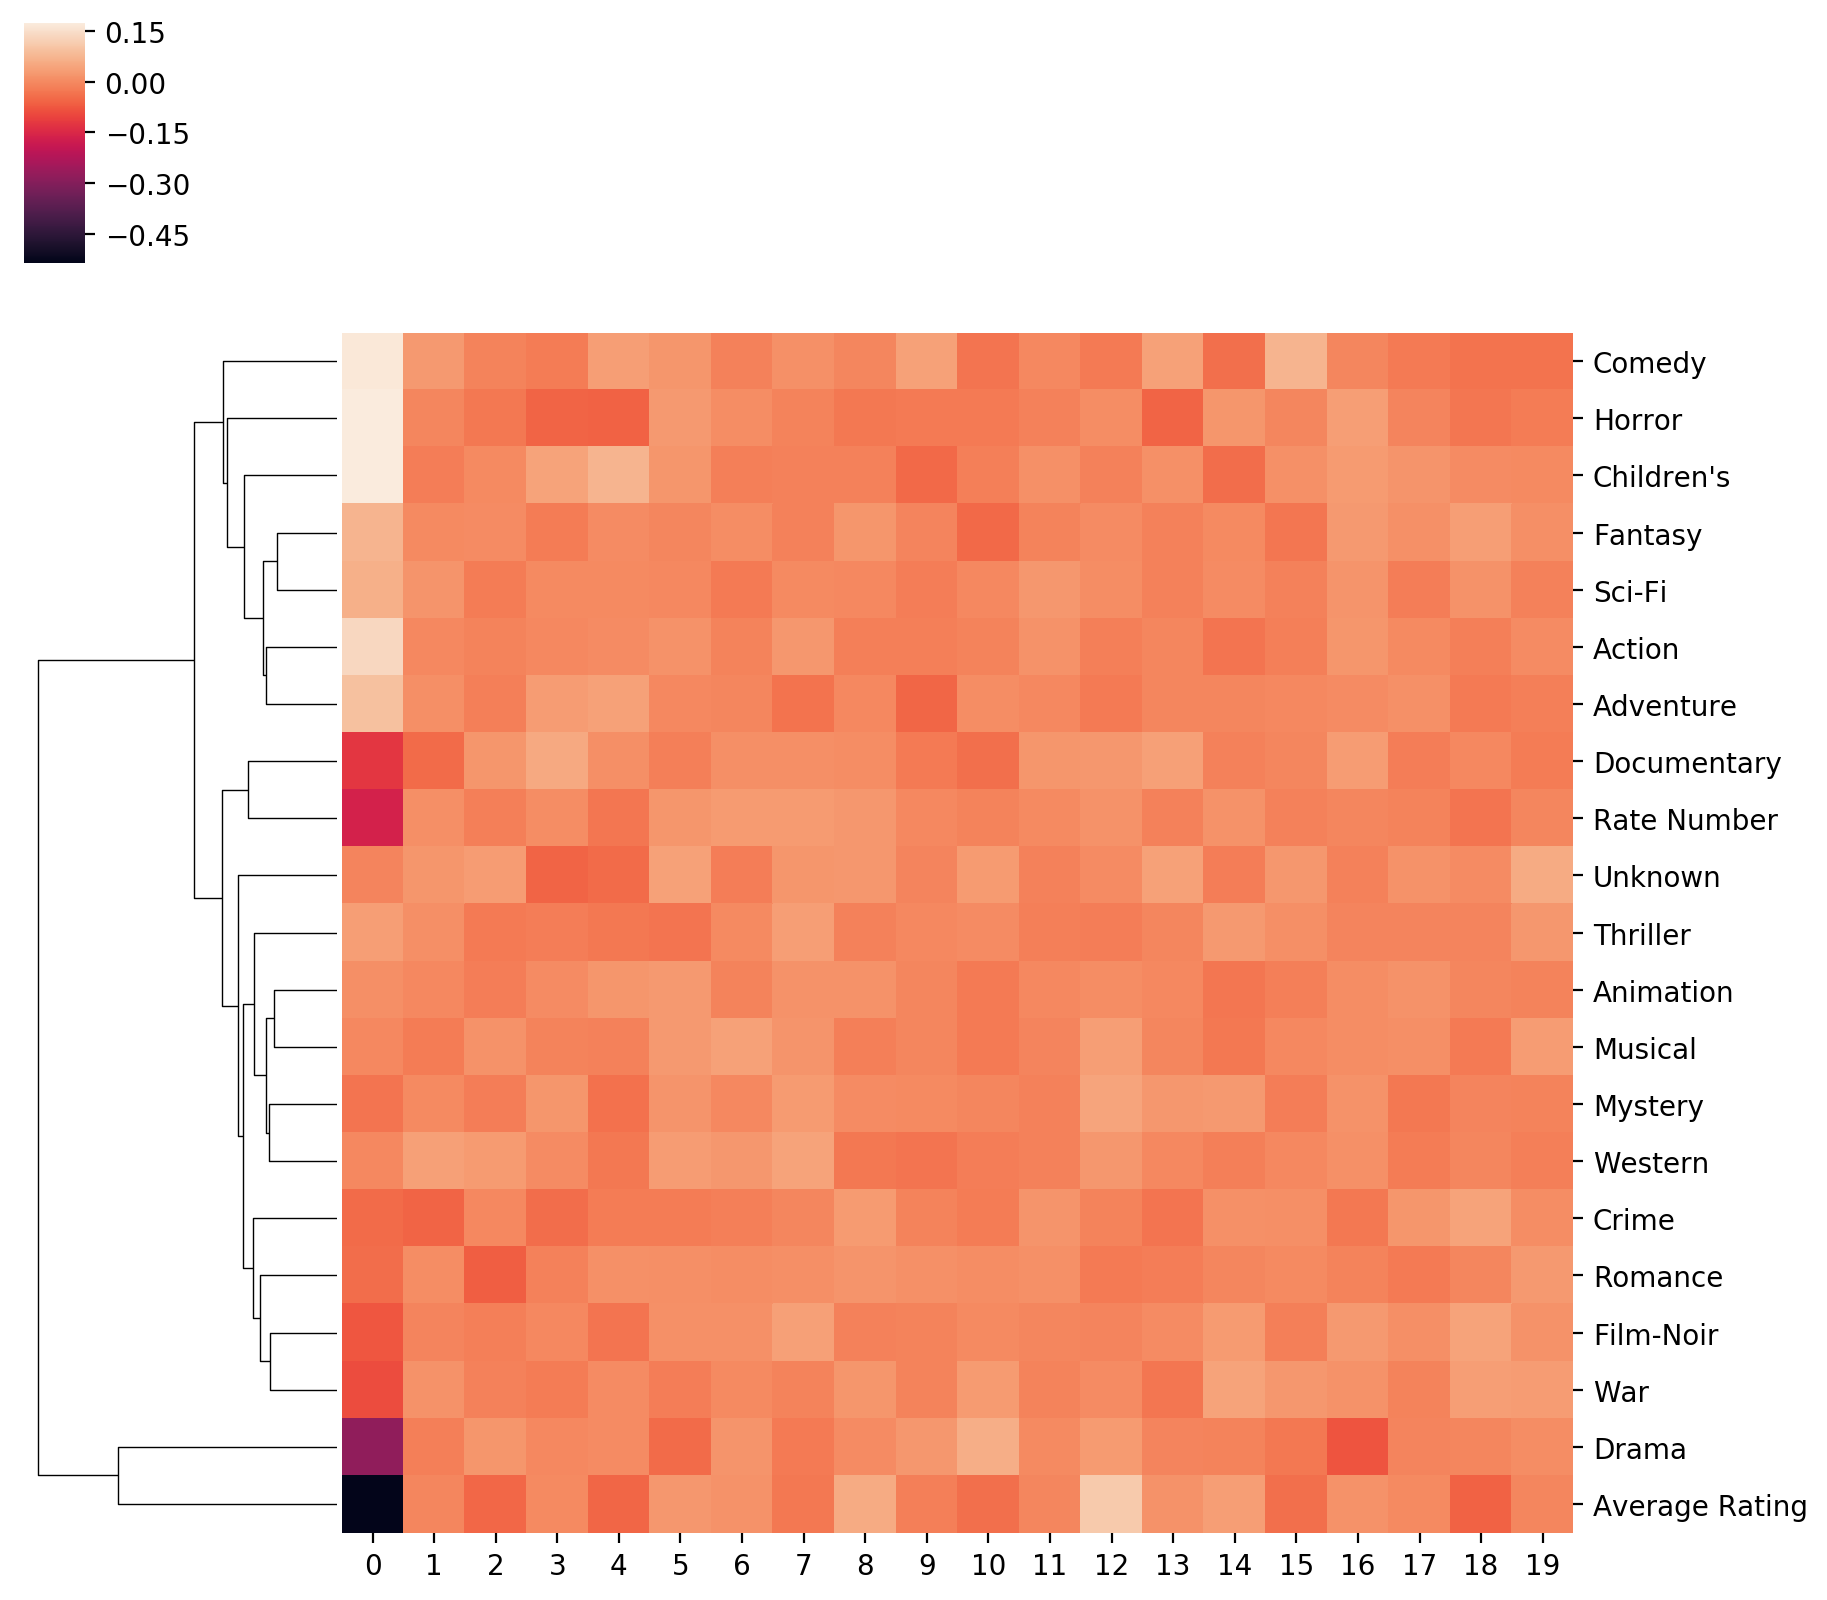

In [57]:
genres = rMovies.columns[2:]
coefs = np.zeros((len(genres), rotV[:, 0:].shape[1]))

for i in range(len(genres)):
    for j in range(rotV[:, 0:].shape[1]):
        coef = np.corrcoef(np.array(rMovies.iloc[:, i + 2]), rotV[:, j])[0, 1]
        coefs[i, j] = coef

pdCoefs = pd.DataFrame(coefs, index=genres)
sns.clustermap(pdCoefs, col_cluster=False, method='average')

In [58]:
genres

Index(['Unknown', 'Action', 'Adventure', 'Animation', 'Children's', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
       'Average Rating', 'Rate Number'],
      dtype='object')

In [73]:
sortedG = list(zip(coefs[:-2, 0], genres[:-2]))

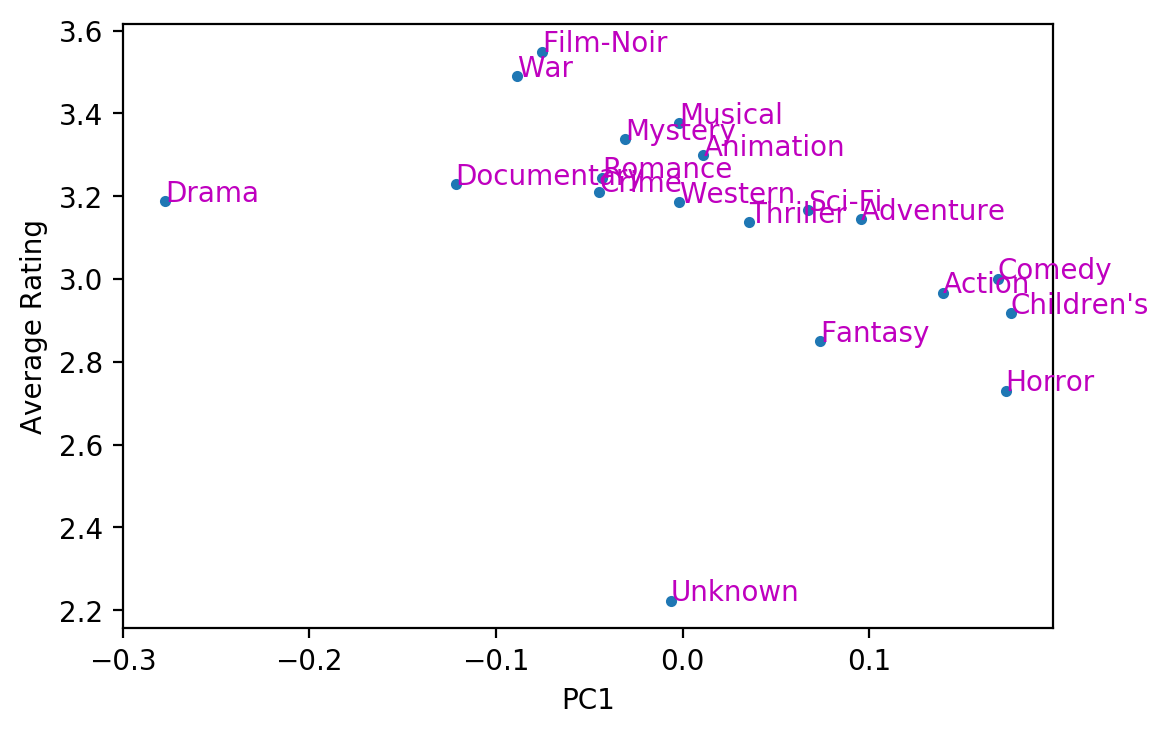

In [89]:
avgGen = []
for gen in genres[:-2]:
    genList = rMovies.loc[rMovies[gen] == 1]
    avgGen.append(genList['Average Rating'].mean())
    
genPCrate = list(zip(coefs[:-2, 0], avgGen, genres[:-2]))

plt.plot([a[0] for a in genPCrate], [a[1] for a in genPCrate], '.')
plt.xlabel('PC1')
plt.ylabel('Average Rating')
for rec in genPCrate:
    plt.text(rec[0], rec[1], rec[2], color='m')

In [85]:
genPCrate

[(-0.006383443844056814, 2.2222222222222223, 'Unknown'),
 (0.13935945551025061, 2.966332403758986, 'Action'),
 (0.095610371855339729, 3.1439673136976105, 'Adventure'),
 (0.011102557256041678, 3.2988130803823776, 'Animation'),
 (0.17570716990354837, 2.916884891868897, "Children's"),
 (0.16877987649563936, 3.0005649618406727, 'Comedy'),
 (-0.044644576638071976, 3.2110147495997547, 'Crime'),
 (-0.12159121405171618, 3.229273094093941, 'Documentary'),
 (-0.27715018769696359, 3.1873534142973314, 'Drama'),
 (0.073835037904098316, 2.849830297920943, 'Fantasy'),
 (-0.075344571335866375, 3.5483508757184237, 'Film-Noir'),
 (0.17306434707681551, 2.730157352996138, 'Horror'),
 (-0.0017867035680093314, 3.376423123539873, 'Musical'),
 (-0.030716545064980418, 3.336813932383023, 'Mystery'),
 (-0.043001272419485204, 3.2440490301647995, 'Romance'),
 (0.067058194025944123, 3.1654460532512894, 'Sci-Fi'),
 (0.035786588834020368, 3.136692475563836, 'Thriller'),
 (-0.088733433891912655, 3.489185428943569, 'Wa

Text(0.5,69,'Factor #')

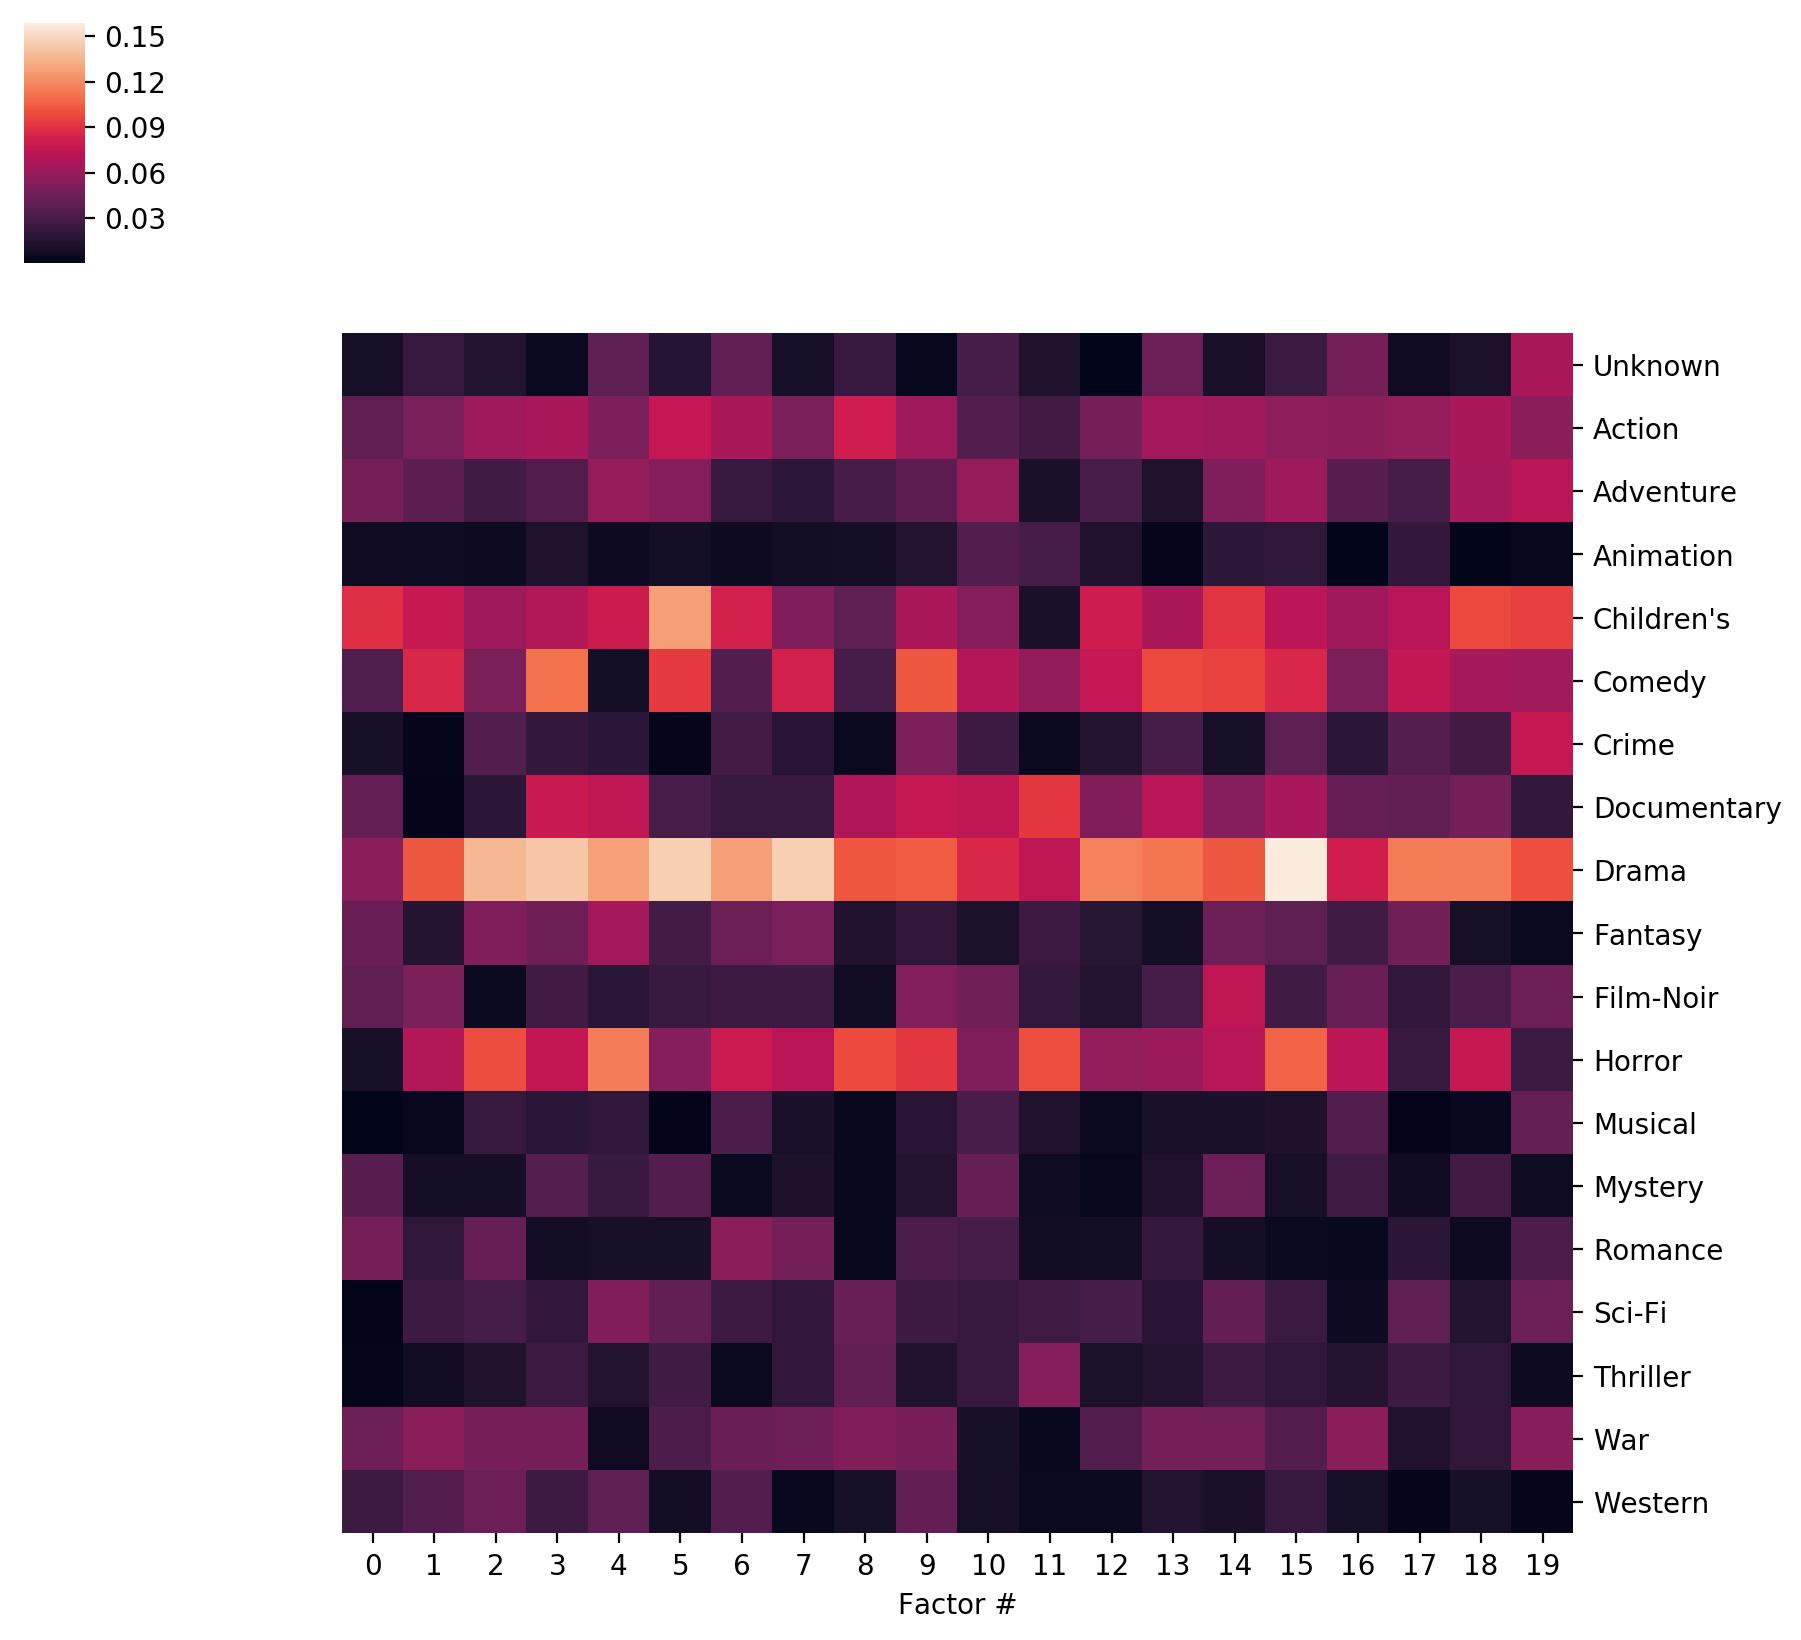

In [13]:
genres = movies.columns[2:]
coefs = np.zeros((len(genres), V.shape[1]))

for i in range(len(genres)):
    for j in range( V.shape[1]):
        coef = np.corrcoef(np.array(movies.iloc[:, i + 2]), V[:, j])[0, 1]
        coefs[i, j] = coef

pdCoefs = pd.DataFrame(np.abs(coefs), index=genres)
cm = sns.clustermap(pdCoefs, col_cluster=False, row_cluster=False, method='average')
cm.ax_heatmap.set_xlabel('Factor #')

Text(0,0.5,'Movie average rating')

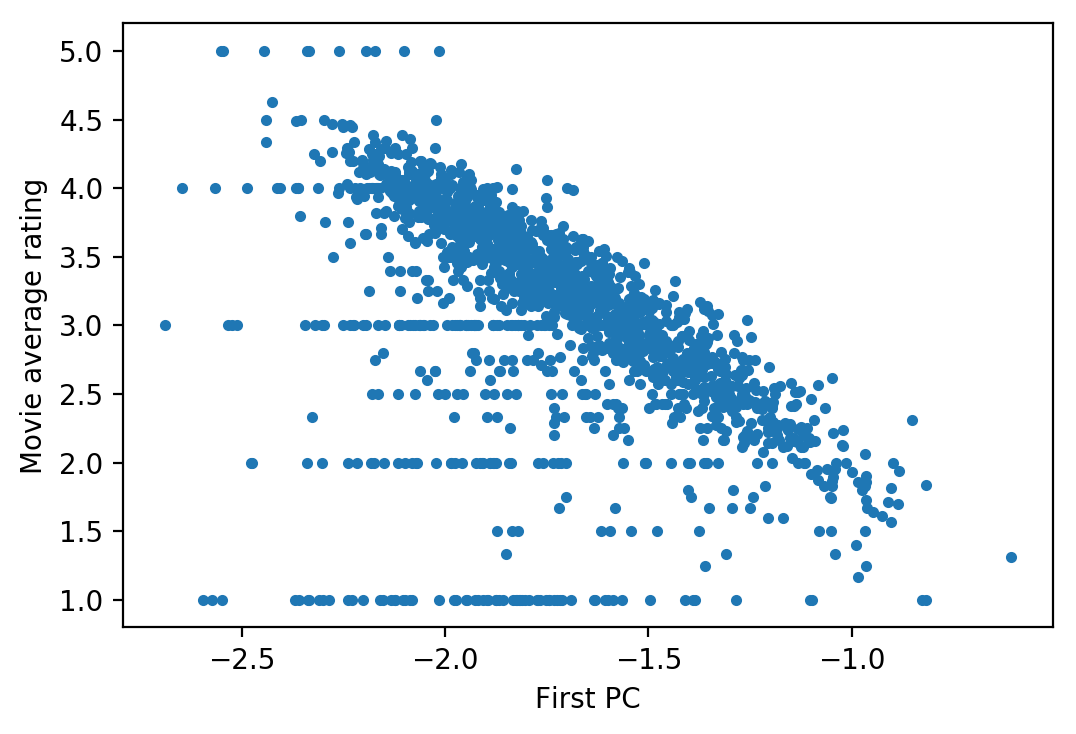

In [14]:
plt.plot(rotV[:,0], rMovies['Average Rating'], '.')
plt.xlabel('First PC')
plt.ylabel('Movie average rating')

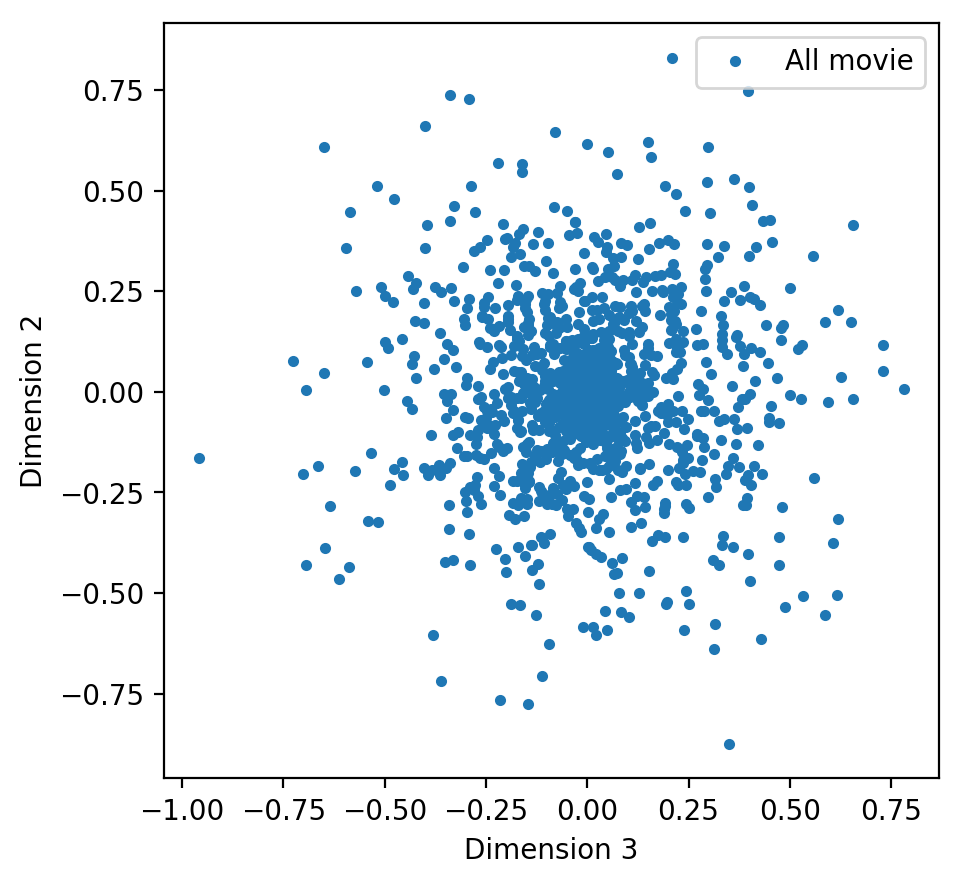

In [21]:
plt.figure(figsize=(5, 5))
plt.plot(rotV[:, 2], rotV[:, 1], '.', label='All movie')
plt.xlabel('Dimension 3')
plt.ylabel('Dimension 2')
plt.legend()

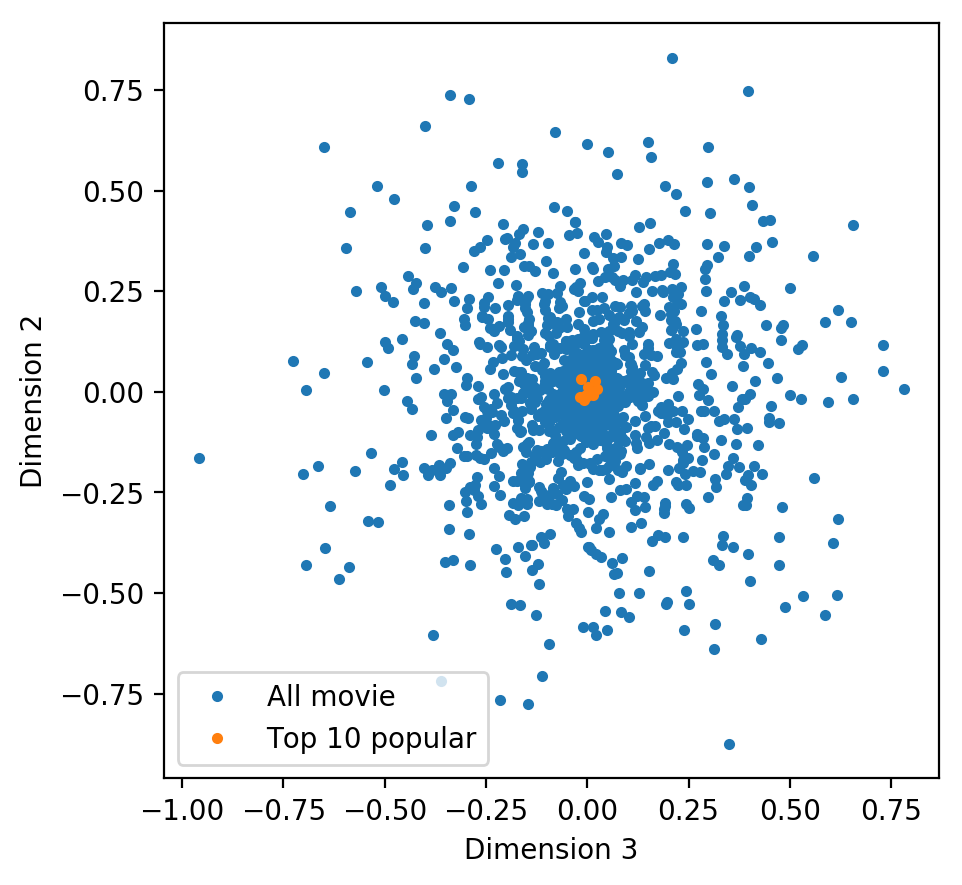

In [23]:
mMovies = copy.deepcopy(rMovies)
sortMovies = mMovies.sort_values(ascending = False, by=['Rate Number'])
topRateN = sortMovies.head(10)

popIndex = np.array(topRateN['Movie ID']) - 1

plt.figure(figsize=(5, 5))
plt.plot(rotV[:, 2], rotV[:, 1], '.', label='All movie')
plt.plot(rotV[popIndex, 2], rotV[popIndex, 1], '.', label='Top 10 popular')
plt.xlabel('Dimension 3')
plt.ylabel('Dimension 2')
plt.legend()

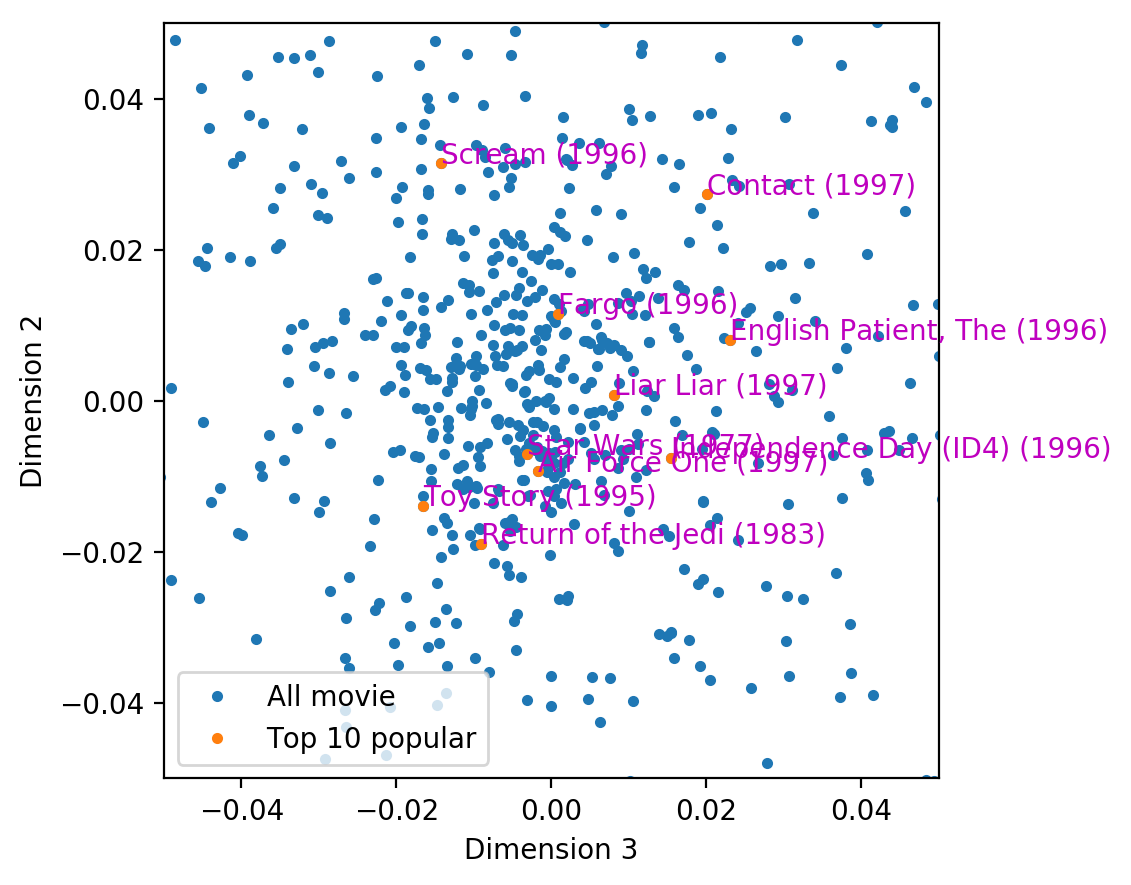

In [28]:
mMovies = copy.deepcopy(rMovies)
sortMovies = mMovies.sort_values(ascending = False, by=['Rate Number'])
topRateN = sortMovies.head(10)

popIndex = np.array(topRateN['Movie ID']) - 1

plt.figure(figsize=(5, 5))
plt.plot(rotV[:, 2], rotV[:, 1], '.', label='All movie')
plt.plot(rotV[popIndex, 2], rotV[popIndex, 1], '.', label='Top 10 popular')
plt.xlabel('Dimension 3')
plt.ylabel('Dimension 2')
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)

for rec in popIndex:
    plt.text(rotV[rec, 2], rotV[rec, 1], topRateN.loc[rec]['Movie Title'], color='m')

plt.legend()

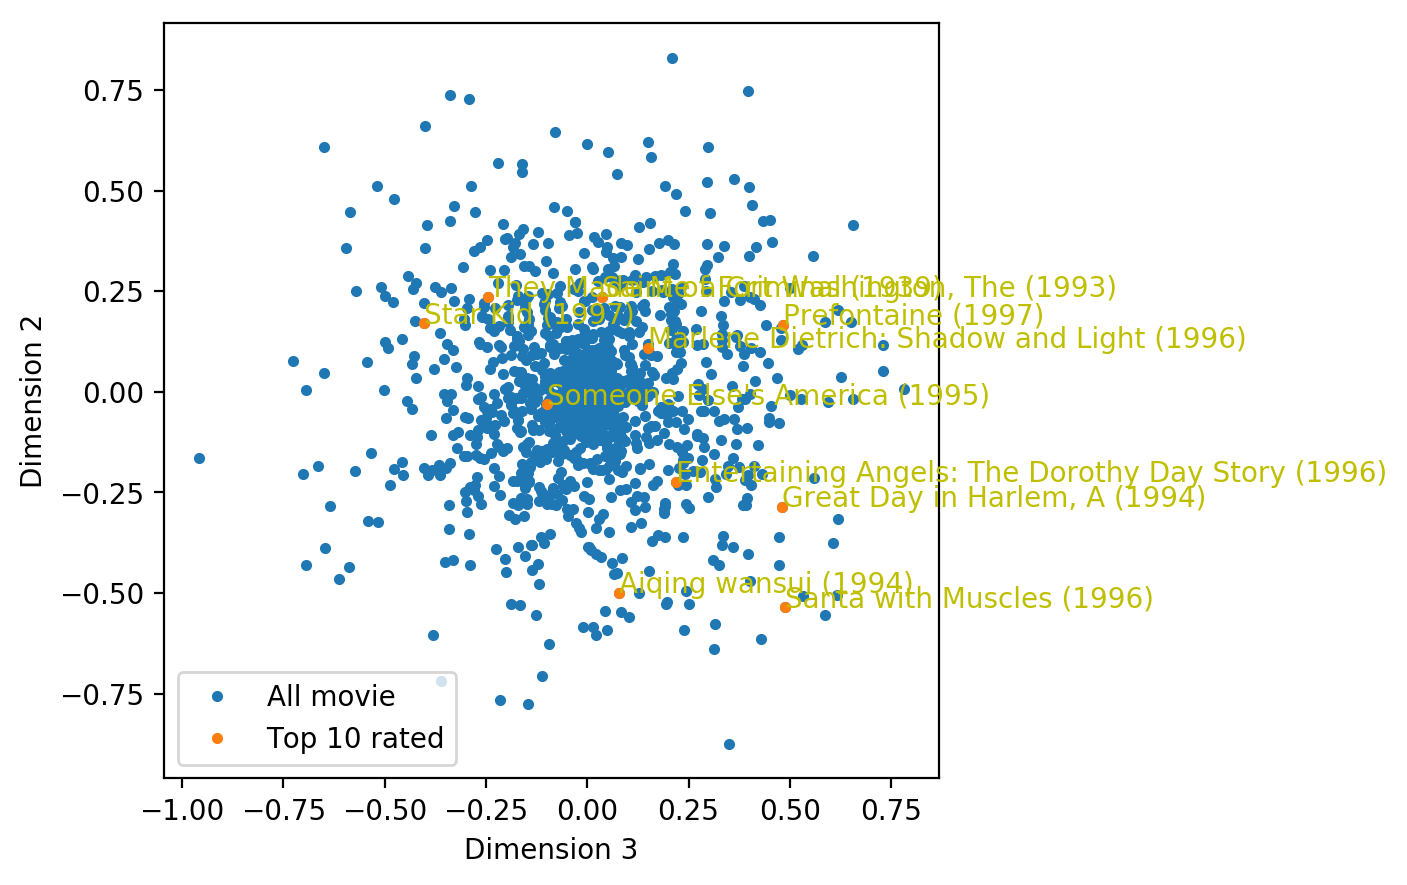

In [29]:
mMovies = copy.deepcopy(rMovies)
sortMovies = mMovies.sort_values(ascending = False, by=['Average Rating'])
topRated = sortMovies.head(10)

rateIndex = np.array(topRated['Movie ID']) - 1

plt.figure(figsize=(5, 5))
plt.plot(rotV[:, 2], rotV[:, 1], '.', label='All movie')
plt.plot(rotV[rateIndex, 2], rotV[rateIndex, 1], '.', label='Top 10 rated')
plt.xlabel('Dimension 3')
plt.ylabel('Dimension 2')

for rec in rateIndex:
    plt.text(rotV[rec, 2], rotV[rec, 1], topRated.loc[rec]['Movie Title'], color='y')


plt.legend()

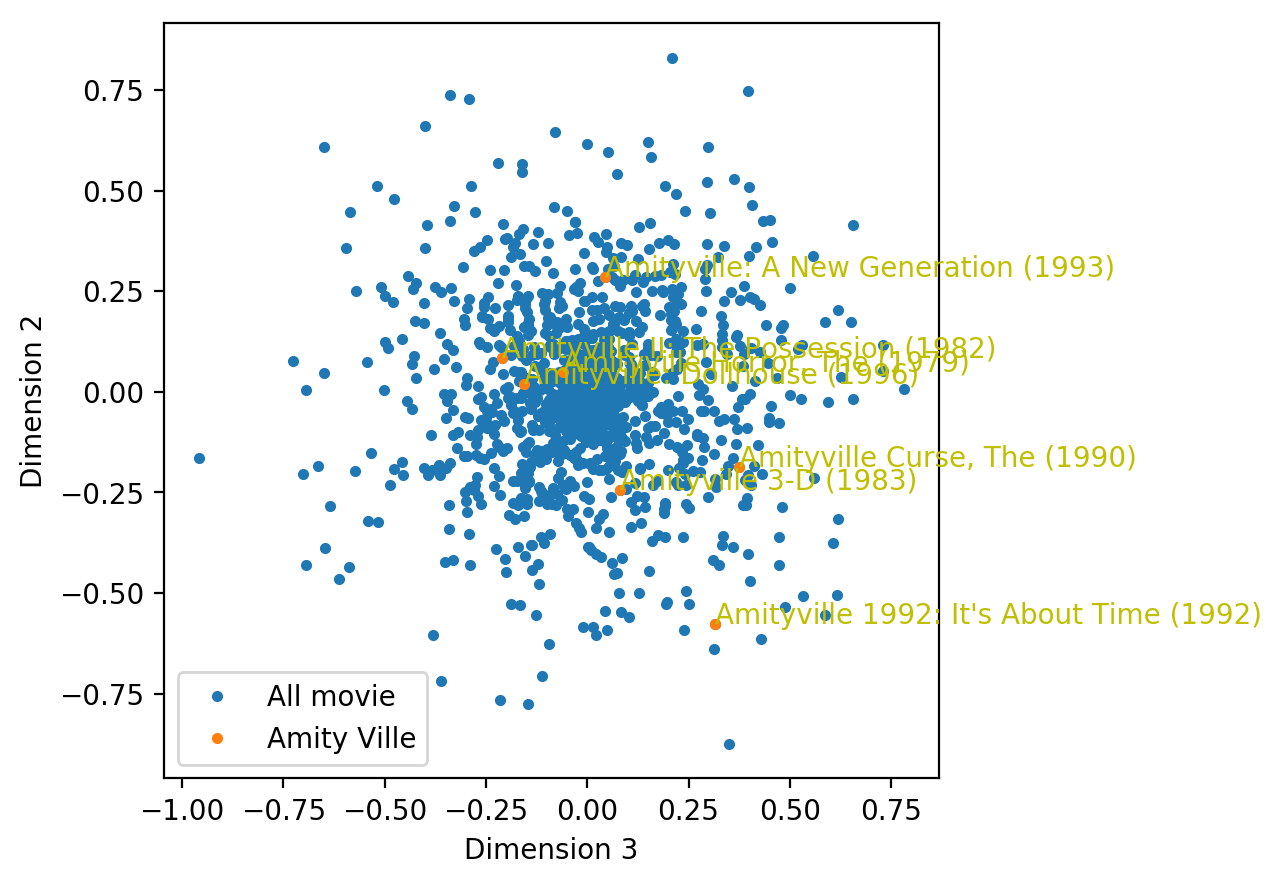

In [43]:
# mMovies = copy.deepcopy(rMovies)
# sortMovies = mMovies.sort_values(ascending = False, by=['Average Rating'])
# topRated = sortMovies.head(10)

# rateIndex = np.array(topRated['Movie ID']) - 1

amityville_idx = np.array([436,437,438,439,440,441,857])
star_wars_idx = np.array([49,171,180])

plt.figure(figsize=(5, 5))
plt.plot(rotV[:, 2], rotV[:, 1], '.', label='All movie')
plt.plot(rotV[amityville_idx, 2], rotV[amityville_idx, 1], '.', label='Amity Ville')
plt.xlabel('Dimension 3')
plt.ylabel('Dimension 2')

for rec in amityville_idx:
    plt.text(rotV[rec, 2], rotV[rec, 1], mMovies.loc[rec]['Movie Title'], color='y')


plt.legend()

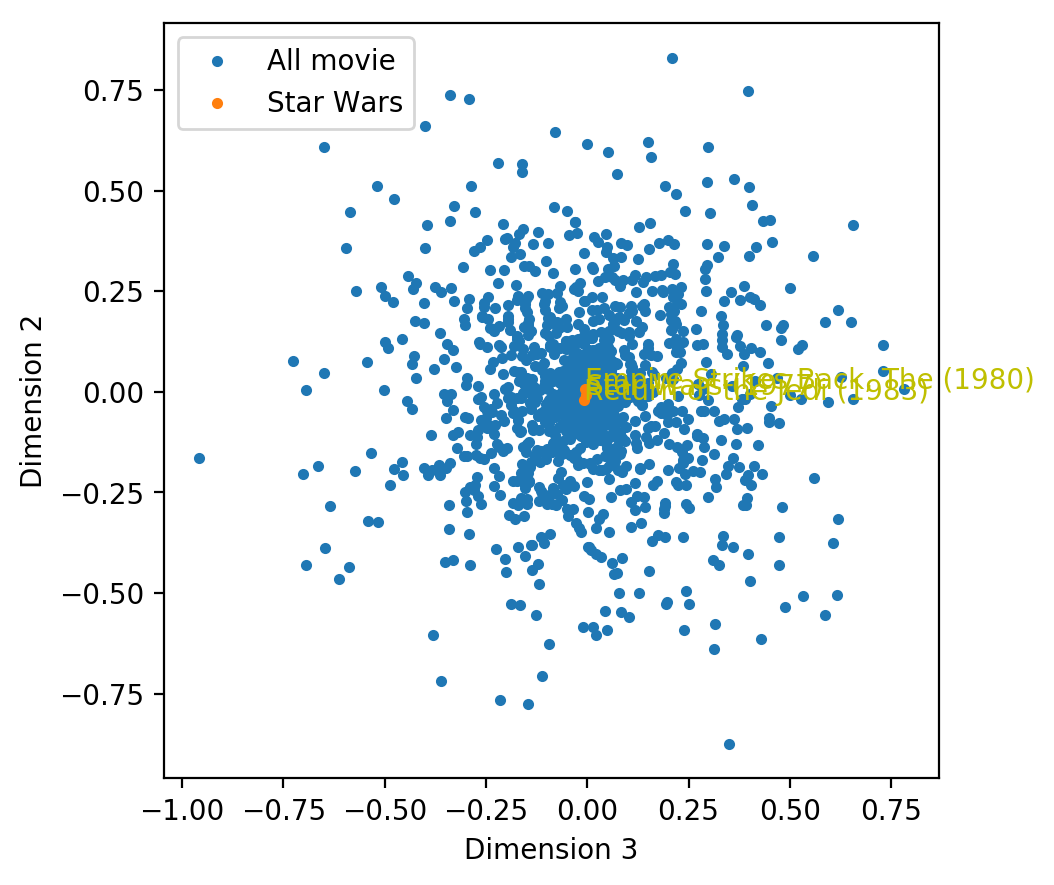

In [44]:
plt.figure(figsize=(5, 5))
plt.plot(rotV[:, 2], rotV[:, 1], '.', label='All movie')
plt.plot(rotV[star_wars_idx, 2], rotV[star_wars_idx, 1], '.', label='Star Wars')
plt.xlabel('Dimension 3')
plt.ylabel('Dimension 2')

for rec in star_wars_idx:
    plt.text(rotV[rec, 2], rotV[rec, 1], mMovies.loc[rec]['Movie Title'], color='y')


plt.legend()

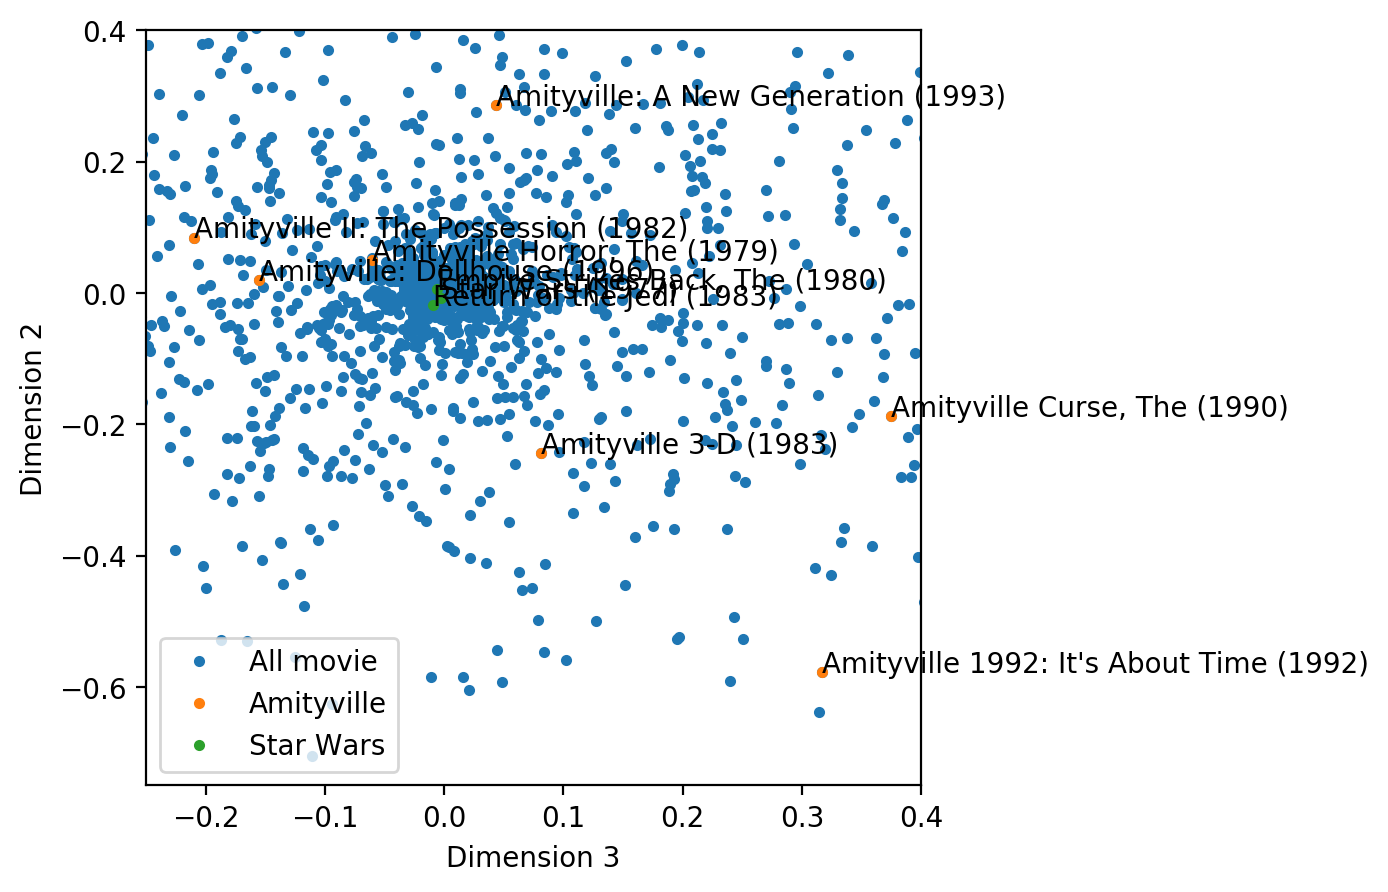

In [50]:
plt.figure(figsize=(5, 5))
plt.plot(rotV[:, 2], rotV[:, 1], '.', label='All movie')
plt.plot(rotV[amityville_idx, 2], rotV[amityville_idx, 1], '.', label='Amityville')
plt.plot(rotV[star_wars_idx, 2], rotV[star_wars_idx, 1], '.', label='Star Wars')
plt.xlabel('Dimension 3')
plt.ylabel('Dimension 2')

for rec in star_wars_idx:
    plt.text(rotV[rec, 2], rotV[rec, 1], mMovies.loc[rec]['Movie Title'], color='k')
for rec in amityville_idx:
    plt.text(rotV[rec, 2], rotV[rec, 1], mMovies.loc[rec]['Movie Title'], color='k')

plt.xlim(-0.25, .40)
plt.ylim(-0.75, .40)

plt.legend()

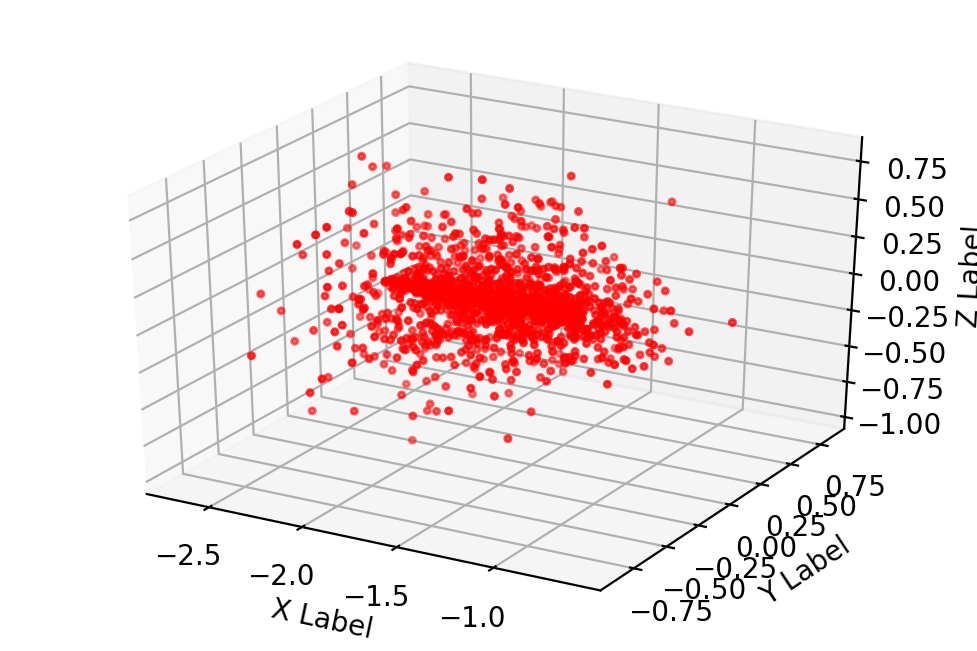

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rotV[:, 0], rotV[:, 1], rotV[:, 2], c='r', marker='.')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [59]:
topRateN

,Movie ID,Movie Title,Unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Average Rating,Rate Number
49,50,Star Wars (1977),0,1,1,0,0,0,0,0,...,0,0,0,1,1,0,1,0,4.358491,583.0
257,258,Contact (1997),0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,3.803536,509.0
99,100,Fargo (1996),0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,4.155512,508.0
180,181,Return of the Jedi (1983),0,1,1,0,0,0,0,0,...,0,0,0,1,1,0,1,0,4.007890,507.0
293,294,Liar Liar (1997),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,3.156701,485.0
285,286,"English Patient, The (1996)",0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,3.656965,481.0
287,288,Scream (1996),0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,3.441423,478.0
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,3.878319,452.0
299,300,Air Force One (1997),0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,3.631090,431.0
120,121,Independence Day (ID4) (1996),0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,3.438228,429.0
